# IBM Capstone Project

### In this project, I will find out the best neighborhood in Toronto for entrepreneurs to open a new Japanese Restaurant by:

* Using multiple datasets from different sources (i.e. Web, Geocode, CSV files, Foursquare API)
* Python Webscraping using Beautifulsoup
* Data Preprocessing
* Data Analysis



In [6]:
#import necessary library
!pip uninstall -y numpy
!pip uninstall -y setuptools
!pip install numpy
!pip install setuptools

!pip install beautifulsoup4
!pip install lxml
!pip install geopy
!pip install folium


import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
!pip install scikit-learn==0.23.1
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Found existing installation: numpy 1.20.3
Uninstalling numpy-1.20.3:
  Successfully uninstalled numpy-1.20.3
Found existing installation: setuptools 49.6.0.post20210108
Uninstalling setuptools-49.6.0.post20210108:
  Successfully uninstalled setuptools-49.6.0.post20210108
     |████████████████████████████████| 821 kB 16.1 MB/s eta 0:00:01
Solving environment: done

# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.5.0               |             py_0   

In [7]:
### Define the url for the data, import data with BeautifulSoup and create a Dataframe with the imported data¶


In [8]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text



In [12]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
#print(table_contents)
df=pd.DataFrame(table_contents)
df.dtypes
df.head()
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head()


PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

We check the dataframe 

In [13]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

#### Now we will group the data based on Borough

In [14]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

Borough PostalCode                 Neighborhood
0  Central Toronto        M4N                Lawrence Park
1  Central Toronto        M4P             Davisville North
2  Central Toronto        M4R           North Toronto West
3  Central Toronto        M4S                   Davisville
4  Central Toronto        M4T  Moore Park, Summerhill East

In [15]:
# Check if we still have any Neighborhoods that are Not Assigned
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]
df = df_grouped

In [16]:
df.shape

(103, 3)

Rearranged the Columns so the PostalCode appears first for easier readibility

In [17]:
df = df[['PostalCode', 'Borough', 'Neighborhood']]
df.head()

PostalCode          Borough                 Neighborhood
0        M4N  Central Toronto                Lawrence Park
1        M4P  Central Toronto             Davisville North
2        M4R  Central Toronto           North Toronto West
3        M4S  Central Toronto                   Davisville
4        M4T  Central Toronto  Moore Park, Summerhill East

### Import Geospatial data in a Dataframe and create a Dataframe with all info with merge based on postal code

In [18]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [19]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode          Borough                 Neighborhood   Latitude  \
0        M4N  Central Toronto                Lawrence Park  43.728020   
1        M4P  Central Toronto             Davisville North  43.712751   
2        M4R  Central Toronto           North Toronto West  43.715383   
3        M4S  Central Toronto                   Davisville  43.704324   
4        M4T  Central Toronto  Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [20]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

### Now we will map Toronto

In [21]:
df_toronto = df
df_toronto.head()

PostalCode          Borough                 Neighborhood   Latitude  \
0        M4N  Central Toronto                Lawrence Park  43.728020   
1        M4P  Central Toronto             Davisville North  43.712751   
2        M4R  Central Toronto           North Toronto West  43.715383   
3        M4S  Central Toronto                   Davisville  43.704324   
4        M4T  Central Toronto  Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [22]:
#Create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [23]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.3971529116505


In [24]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [25]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

### Extract information with Foursquare request

In [26]:
# The code was removed by Watson Studio for sharing.

Credentials Stored


### Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.

First, let's create the GET request URL


In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
First Canadian Place, Underground city
Christie
Enclave of M5E
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Enclave of M4L
Parkview Hill, Woodbine Gardens
Woodbine Heights
Leaside
Thorncliffe Park
The Danforth  East
New Toronto, Mimico South, Humber 

In [30]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Lawrence Park              43.728020              -79.388790   
1     Lawrence Park              43.728020              -79.388790   
2     Lawrence Park              43.728020              -79.388790   
3     Lawrence Park              43.728020              -79.388790   
4  Davisville North              43.712751              -79.390197   

                            Venue  Venue Latitude  Venue Longitude  \
0              Booty Camp Fitness       43.728051       -79.387853   
1            Lawrence Park Ravine       43.726963       -79.394382   
2              Zodiac Swim School       43.728532       -79.382860   
3  TTC Bus #162 - Lawrence-Donway       43.728026       -79.382805   
4                   Sherwood Park       43.716551       -79.387776   

         Venue Category  
0  Gym / Fitness Center  
1                  Park  
2           Swim School  
3              Bus Line  
4                  Park

Lets check how many venues per neighborhood

In [31]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  6   
Bathurst Manor, Wilson Heights, Downsview North                        16   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      24   
Berczy Park                                                            48   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           23   
CN Tower, King and Spadina, Railway Lands, Harb...                     18   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               7   
Central Bay Street                                                     63   
Christie                                                               15   
Church and Wellesley                                                   65   
Clairville, Humberwood, Woodbine Downs, West Hu...                      4   
Clarks Corners, Tam O'Shanter, Sullivan                                12   
Cliffside, Cliffcrest, Scarborough Village West                         3   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             28   
Davisville North                                                       10   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         5   
Don Mills South                                                        17   
Dorset Park, Wexford Heights, Scarborough Town ...                      6   
Downsview Central                                                       4   
Downsview East                                                          3   
Downsview Northwest                                                     6   
Downsview West                                                          5   
Dufferin, Dovercourt Village                                           14   
Enclave of L4W                                                         14   
Enclave of M4L                                                         15   
Enclave of M5E                                                         84   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           60   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                        10   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          18   
Hillcrest Village                                                       5   
Humber Summit                                                           2   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         19   
Kennedy Park, Ionview, East Birchmount Park                             6   
Kensington Market, Chinatown, Grange Park                              56   
Kingsview Village, St. Phillips, Martin Grove G...                      3   
Lawrence Manor, Lawrence Heights                

### Check how many unique venues are there

In [32]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 252 uniques categories.


In [33]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Gym / Fitness Center' 'Park' 'Swim School' 'Bus Line' 'Breakfast Spot'
 'Food & Drink Shop' 'Department Store' 'Sandwich Place' 'Hotel' 'Gym'
 'Playground' 'Pizza Place' 'Spa' 'Clothing Store' 'Fast Food Restaurant'
 'Chinese Restaurant' 'Diner' 'Coffee Shop' 'Café' 'Sporting Goods Shop'
 'Toy / Game Store' 'Rental Car Location' 'Dessert Shop'
 'Indian Restaurant' 'Seafood Restaurant' 'Sushi Restaurant'
 'Thai Restaurant' 'Italian Restaurant' 'Gas Station' 'Greek Restaurant'
 'Pharmacy' 'Brewery' 'American Restaurant' 'Fried Chicken Joint'
 'Restaurant' 'Tennis Court' 'Bank' 'Vietnamese Restaurant' 'Bagel Shop'
 'Light Rail Station' 'Garden' 'Music Venue' 'Pool' 'Trail'
 'Jewelry Store' 'Middle Eastern Restaurant' 'History Museum' 'Pub'
 'BBQ Joint' 'Liquor Store' 'Grocery Store' 'Bakery' 'Japanese Restaurant'
 'Deli / Bodega' 'Gastropub' 'Caribbean Restaurant' 'Taiwanese Restaurant'
 'Beer Store' 'Pet Store' 'Yoga Studio' 'Snack Place' 'Flower Shop'
 'Dance 

## Are there any Japanese Restaurants in the venues?

In [34]:
"Japanese Restaurant" in toronto_venues['Venue Category'].unique()

True

### Now we will analyze each neighborhood

In [35]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2000, 253)


Neighborhoods  Adult Boutique  Afghan Restaurant  Airport  \
0     Lawrence Park               0                  0        0   
1     Lawrence Park               0                  0        0   
2     Lawrence Park               0                  0        0   
3     Lawrence Park               0                  0        0   
4  Davisville North               0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0          0       0           0              0          0         0   
1          0       0           0              0          0         0   
2          0       0           0              0          0         0   
3          0       0           0              0          0         0   
4          0       0           0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Burger Joint  Burrito Place  Bus Line  Bu

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [36]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(100, 253)


Neighborhoods  Adult Boutique  \
0                                        Agincourt             0.0   
1                           Alderwood, Long Branch             0.0   
2  Bathurst Manor, Wilson Heights, Downsview North             0.0   
3                                  Bayview Village             0.0   
4                Bedford Park, Lawrence Manor East             0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.041667   

   Antique Shop  Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0           0.0       0.0          0.0                  0.0               0.0   
1           0.0       0.0          0.0                  0.0               0.0   
2           0.0       0.0          0.0                  0.0               0.0   
3           0.0       0.0          0.0                  0.0               0.0   
4           0.0       0.0          0.0                  0.0               0.0   

   Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  \
0                 0.0          0.0            0.0        0.0         0.0   
1                 0.0          0.0            0.0        0.0         0.0   
2                 0.0          0.0            0.0        0.0         0.0   
3                 0.0          0.0            0.0        0.0         0.0   
4                 0.0          0.0            0.0        0.0         0.0   

   Bagel Shop  Bakery   Bank  Bar  Baseball Field  Baseball Stadium  \
0         0.0     0.0  0.000  0.0             0.0               0.0   
1         0.0     0.0  0.000  0.0             0.0               0.0   
2         0.0     0.0  0.125  0.0             0.0               0.0   
3         0.0     0.0  0.250  0.0             0.0               0.0   
4         0.0     0.0  0.000  0.0             0.0               0.0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Board Shop  \
0         0.0                 0.0        0.0     0.0         0.0   
1         0.0                 0.0        0.0     0.0         0.0   
2         0.0                 0.0        0.0     0.0         0.0   
3         0.0                 0.0        0.0     0.0         0.0   
4         0.0                 0.0        0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0            0.0        0.0  0.000000                   0.0            0.25   
1            0.0        0.0  0.000000                   0.0            0.00   
2            0.0        0.0  0.000000                   0.0            0.00   
3            0.0        0.0  0.000000                   0.0            0.00   
4            0.0        0.0  0.041667                   0.0            0.00   

   Brewery  Bridal Shop  Bubble 

In [37]:
jap = to_grouped[["Neighborhoods","Japanese Restaurant"]]
jap.head() #.head() shows the first five rows only

Neighborhoods  Japanese Restaurant
0                                        Agincourt             0.000000
1                           Alderwood, Long Branch             0.000000
2  Bathurst Manor, Wilson Heights, Downsview North             0.000000
3                                  Bayview Village             0.250000
4                Bedford Park, Lawrence Manor East             0.041667

In [38]:
jap = jap.rename(columns={'Neighborhoods':'Neighborhood'})

### Now we will cluster the neighborhoods
We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [39]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = jap.drop(['Neighborhood'], axis=1)

In [40]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 1, 2, 2, 0, 2, 0, 0], dtype=int32)

In [41]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [42]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

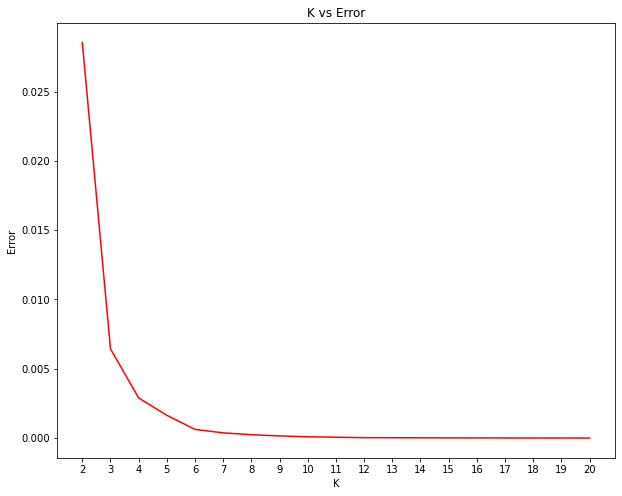

In [44]:
import seaborn as sns

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [46]:
!conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytest-runner-5.3.1        |     pyhd3eb1b0_0          11 KB
    yellowbrick-1.2            |           py37_0         284 KB  districtdatalabs
    ------------------------------------------------------------
                                           Total:         294 KB

The following NEW packages will be INSTALLED:

  pytest-runner      pkgs/main/noarch::pytest-runner-5.3.1-pyhd3eb1b0_0
  yellowbrick        districtdatalabs/linux-64::yellowbrick-1.2-py37_0



yellowbrick-1.2      | 284 KB    | ##################################### | 100% 
pytest-runner-5.3.1  | 11 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transac

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


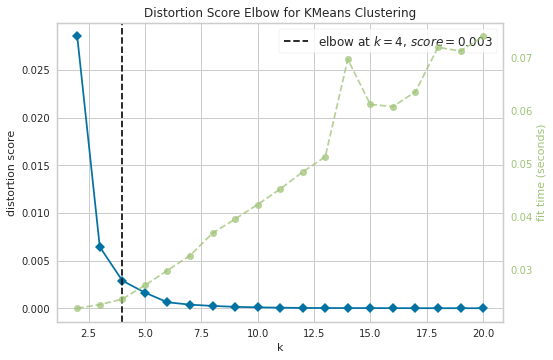

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

We see that the optimum K value is 4 so we will have a resulting of 4 clusters

In [48]:
kclusters = 4

toronto_grouped_clustering = jap.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 2, 0, 0, 1, 0, 1, 1], dtype=int32)

In [49]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = jap.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [50]:
to_merged.head()

Neighborhood  Japanese Restaurant  \
0                                        Agincourt             0.000000   
1                           Alderwood, Long Branch             0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North             0.000000   
3                                  Bayview Village             0.250000   
4                Bedford Park, Lawrence Manor East             0.041667   

   Cluster Labels  
0               1  
1               1  
2               1  
3               2  
4               0

In [51]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2000, 9)


Neighborhood  Japanese Restaurant  Cluster Labels  \
0               Agincourt                  0.0               1   
0               Agincourt                  0.0               1   
0               Agincourt                  0.0               1   
0               Agincourt                  0.0               1   
1  Alderwood, Long Branch                  0.0               1   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                     El Pulgarcito       43.792648       -79.259208   
0                          Twilight       43.791999       -79.258584   
0                            Mark's       43.791179       -79.259714   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0             Clothing Store  
1                Pizza Place

In [52]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2000, 9)


Neighborhood  Japanese Restaurant  \
33                       Fairview, Henry Farm, Oriole             0.033333   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city             0.040000   
34             First Canadian Place, Underground city          

Lets check how many Japanese Restaurant are there

In [53]:
to_merged['Venue Category'].value_counts()['Japanese Restaurant']

46

In [54]:
print('We see that there are a total of', to_merged['Venue Category'].value_counts()['Japanese Restaurant'] ,'locations with Italian Restaurants in Toronto')
print('We will create a new dataframe with the Neighborhood and Japanese Restaurants')

We see that there are a total of 46 locations with Italian Restaurants in Toronto
We will create a new dataframe with the Neighborhood and Japanese Restaurants


In [55]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### How many Neighborhoods per Cluster?

In [56]:
jap["Cluster Labels"] = kmeans.labels_
jap.head()

Neighborhood  Japanese Restaurant  \
0                                        Agincourt             0.000000   
1                           Alderwood, Long Branch             0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North             0.000000   
3                                  Bayview Village             0.250000   
4                Bedford Park, Lawrence Manor East             0.041667   

   Cluster Labels  
0               1  
1               1  
2               1  
3               2  
4               0

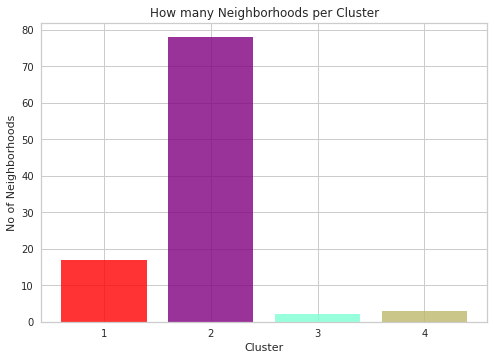

In [57]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = jap['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [58]:
# How many neighborhoods in each cluster
jap['Cluster Labels'].value_counts()

1    78
0    17
3     3
2     2
Name: Cluster Labels, dtype: int64

## Analysis of each Cluster

### Cluster 1

In [59]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                 Neighborhood
0  Central Toronto                Lawrence Park
1  Central Toronto             Davisville North
2  Central Toronto           North Toronto West
3  Central Toronto                   Davisville
4  Central Toronto  Moore Park, Summerhill East

In [60]:
# Red 
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

Borough                                  Neighborhood  \
0           Downtown Toronto                   St. James Town, Cabbagetown   
1           Downtown Toronto                   St. James Town, Cabbagetown   
2           Downtown Toronto                   St. James Town, Cabbagetown   
3           Downtown Toronto                   St. James Town, Cabbagetown   
4           Downtown Toronto                   St. James Town, Cabbagetown   
5           Downtown Toronto                   St. James Town, Cabbagetown   
6           Downtown Toronto                   St. James Town, Cabbagetown   
7           Downtown Toronto                   St. James Town, Cabbagetown   
8           Downtown Toronto                   St. James Town, Cabbagetown   
9           Downtown Toronto                   St. James Town, Cabbagetown   
10          Downtown Toronto                   St. James Town, Cabbagetown   
11          Downtown Toronto                   St. James Town, Cabbagetown   
12          Downtown Toronto                   St. James Town, Cabbagetown   
13          Downtown Toronto                   St. James Town, Cabbagetown   
14          Downtown Toronto                   St. James Town, Cabbagetown   
15          Downtown Toronto                   St. James Town, Cabbagetown   
16          Downtown Toronto                   St. James Town, Cabbagetown   
17          Downtown Toronto                   St. James Town, Cabbagetown   
18          Downtown Toronto                   St. James Town, Cabbagetown   
19          Downtown Toronto                   St. James Town, Cabbagetown   
20          Downtown Toronto                   St. James Town, Cabbagetown   
21          Downtown Toronto                   St. James Town, Cabbagetown   
22          Downtown Toronto                   St. James Town, Cabbagetown   
23          Downtown Toronto                   St. James Town, Cabbagetown   
24          Downtown Toronto                   St. James Town, Cabbagetown   
25          Downtown Toronto                   St. James Town, Cabbagetown   
26          Downtown Toronto                   St. James Town, Cabbagetown   
27          Downtown Toronto                   St. James Town, Cabbagetown   
28          Downtown Toronto                   St. James Town, Cabbagetown   
29          Downtown Toronto                   St. James Town, Cabbagetown   
30          Downtown Toronto                   St. James Town, Cabbagetown   
31          Downtown Toronto                   St. James Town, Cabbagetown   
32          Downtown Toronto                   St. James Town, Cabbagetown   
33          Downtown Toronto                   St. James Town, Cabbagetown   
34          Downtown Toronto                   St. James Town, Cabbagetown   
35          Downtown Toronto                   St. James Town, Cabbagetown   
36          Downtown Toronto                      Garden District, Ryerson   
37          Downtown Toronto                      Garden District, Ryerson   
38          Downtown Toronto                      Garden District, Ryerson   
39          Downtown Toronto                      Garden District, Ryerson   
40          Downtown Toronto                      Garden District, Ryerson   
41          Downtown Toronto                      Garden District, Ryerson   
42          Downtown Toronto                      Garden District, Ryerson   
43          Downtown Toronto                      Garden District, Ryerson   
44          Downtown Toronto                      Garden District, Ryerson   
45          Downtown Toronto                      Garden District, Ryerson   
46          Downtown Toronto                      Garden District, Ryerson   
47          Downtown Toronto                      Garden District, Ryerson   
48          Downtown Toronto                      Garden District, Ryerson   
49          Downtown Toronto                      Garden District, Ryerson   
50          Downtown Toronto               

### Cluster 2

In [61]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')

In [62]:
df_cluster2.sort_values(["Japanese Restaurant"], ascending=False)

Borough  \
219        Downtown Toronto   
205        Downtown Toronto   
174        Downtown Toronto   
175        Downtown Toronto   
176        Downtown Toronto   
177        Downtown Toronto   
178        Downtown Toronto   
179        Downtown Toronto   
180        Downtown Toronto   
181        Downtown Toronto   
182        Downtown Toronto   
183        Downtown Toronto   
184        Downtown Toronto   
185        Downtown Toronto   
186        Downtown Toronto   
187        Downtown Toronto   
188        Downtown Toronto   
189        Downtown Toronto   
190        Downtown Toronto   
191        Downtown Toronto   
192        Downtown Toronto   
193        Downtown Toronto   
194        Downtown Toronto   
195        Downtown Toronto   
196        Downtown Toronto   
197        Downtown Toronto   
198        Downtown Toronto   
199        Downtown Toronto   
200        Downtown Toronto   
201        Downtown Toronto   
203        Downtown Toronto   
173        Downtown Toronto   
172        Downtown Toronto   
171        Downtown Toronto   
155        Downtown Toronto   
142        Downtown Toronto   
143        Downtown Toronto   
144        Downtown Toronto   
145        Downtown Toronto   
146        Downtown Toronto   
147        Downtown Toronto   
148        Downtown Toronto   
149        Downtown Toronto   
150        Downtown Toronto   
151        Downtown Toronto   
152        Downtown Toronto   
153        Downtown Toronto   
154        Downtown Toronto   
156        Downtown Toronto   
170        Downtown Toronto   
157        Downtown Toronto   
158        Downtown Toronto   
159        Downtown Toronto   
160        Downtown Toronto   
161        Downtown Toronto   
162        Downtown Toronto   
163        Downtown Toronto   
164        Downtown Toronto   
165        Downtown Toronto   
166        Downtown Toronto   
167        Downtown Toronto   
168        Downtown Toronto   
169        Downtown Toronto   
204        Downtown Toronto   
202        Downtown Toronto   
206        Downtown Toronto   
233        Downtown Toronto   
226        Downtown Toronto   
227        Downtown Toronto   
228        Downtown Toronto   
229        Downtown Toronto   
230        Downtown Toronto   
231        Downtown Toronto   
232        Downtown Toronto   
234        Downtown Toronto   
224        Downtown Toronto   
235        Downtown Toronto   
236        Downtown Toronto   
237        Downtown Toronto   
238        Downtown Toronto   
207        Downtown Toronto   
240        Downtown Toronto   
241        Downtown Toronto   
225        Downtown Toronto   
239        Downtown Toronto   
223        Downtown Toronto   
214        Downtown Toronto   
222        Downtown Toronto   
209        Downtown Toronto   
210        Downtown Toronto   
211        Downtown Toronto   
212        Downtown Toronto   
213        Downtown Toronto   
208        Downtown Toronto   
215        Downtown Toronto   
217        Downtown Toronto   
218        Downtown Toronto   
220        Downtown Toronto   
221        Downtown Toronto   
216        Downtown Toronto   
606             Scarborough   
600             Scarborough   
601             Scarborough   
602             Scarborough   
603             Scarborough   
604             Scarborough   
605             Scarborough   
608             Scarborough   
607             Scarborough   
581              North York   
580              North York   
579              North York   
578              North York   
598             Scarborough   
577              North York   
599             Scarborough   
590             Scarborough   
597             Scarborough   
587              North York   
582              North York   
575              North York   
583              North York   
584              North York   
585              North York   
586              North York   
588              North York   
596             Scarborough   
589             Scarborough   
591             Scarb

In [63]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Japanese Restaurant']

1

### Cluster 3

In [64]:
# Ligth Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough     Neighborhood  Japanese Restaurant  Cluster Labels  \
0  North York  Bayview Village                 0.25               2   
1  North York  Bayview Village                 0.25               2   
2  North York  Bayview Village                 0.25               2   
3  North York  Bayview Village                 0.25               2   
4  North York  Don Mills North                 0.20               2   
5  North York  Don Mills North                 0.20               2   
6  North York  Don Mills North                 0.20               2   
7  North York  Don Mills North                 0.20               2   
8  North York  Don Mills North                 0.20               2   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.786947              -79.385975   
1              43.786947              -79.385975   
2              43.786947              -79.385975   
3              43.786947              -79.385975   
4              43.745906              -79.352188   
5              43.745906              -79.352188   
6              43.745906              -79.352188   
7              43.745906              -79.352188   
8              43.745906              -79.352188   

                           Venue  Venue Latitude  Venue Longitude  \
0    Maxim's Cafe and Patisserie       43.787863       -79.380751   
1  Sun Star Chinese Cuisine 翠景小炒       43.787914       -79.381234   
2                     Kaga Sushi       43.787758       -79.381090   
3                TD Canada Trust       43.788074       -79.380367   
4                  Baretto Caffé       43.744456       -79.346460   
5                   Island Foods       43.745866       -79.346035   
6                     LA Fitness       43.747665       -79.347077   
7                    Gonoe Sushi       43.745737       -79.345991   
8         Elite Basketball Camps       43.748790       -79.354228   

         Venue Category  
0                  Café  
1    Chinese Restaurant  
2   Japanese Restaurant  
3                  Bank  
4                  Café  
5  Caribbean Restaurant  
6                   Gym  
7   Japanese Restaurant  
8    Athletics & Sports

### Cluster 4

In [65]:
# Sand
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough                    Neighborhood  Japanese Restaurant  \
0    Downtown Toronto            Church and Wellesley             0.076923   
1    Downtown Toronto            Church and Wellesley             0.076923   
2    Downtown Toronto            Church and Wellesley             0.076923   
3    Downtown Toronto            Church and Wellesley             0.076923   
4    Downtown Toronto            Church and Wellesley             0.076923   
5    Downtown Toronto            Church and Wellesley             0.076923   
6    Downtown Toronto            Church and Wellesley             0.076923   
7    Downtown Toronto            Church and Wellesley             0.076923   
8    Downtown Toronto            Church and Wellesley             0.076923   
9    Downtown Toronto            Church and Wellesley             0.076923   
10   Downtown Toronto            Church and Wellesley             0.076923   
11   Downtown Toronto            Church and Wellesley             0.076923   
12   Downtown Toronto            Church and Wellesley             0.076923   
13   Downtown Toronto            Church and Wellesley             0.076923   
14   Downtown Toronto            Church and Wellesley             0.076923   
15   Downtown Toronto            Church and Wellesley             0.076923   
16   Downtown Toronto            Church and Wellesley             0.076923   
17   Downtown Toronto            Church and Wellesley             0.076923   
18   Downtown Toronto            Church and Wellesley             0.076923   
19   Downtown Toronto            Church and Wellesley             0.076923   
20   Downtown Toronto            Church and Wellesley             0.076923   
21   Downtown Toronto            Church and Wellesley             0.076923   
22   Downtown Toronto            Church and Wellesley             0.076923   
23   Downtown Toronto            Church and Wellesley             0.076923   
24   Downtown Toronto            Church and Wellesley             0.076923   
25   Downtown Toronto            Church and Wellesley             0.076923   
26   Downtown Toronto            Church and Wellesley             0.076923   
27   Downtown Toronto            Church and Wellesley             0.076923   
28   Downtown Toronto            Church and Wellesley             0.076923   
29   Downtown Toronto            Church and Wellesley             0.076923   
30   Downtown Toronto            Church and Wellesley             0.076923   
31   Downtown Toronto            Church and Wellesley             0.076923   
32   Downtown Toronto            Church and Wellesley             0.076923   
33   Downtown Toronto            Church and Wellesley             0.076923   
34   Downtown Toronto            Church and Wellesley             0.076923   
35   Downtown Toronto            Church and Wellesley             0.076923   
36   Downtown Toronto            Church and Wellesley             0.076923   
37   Downtown Toronto            Church and Wellesley             0.076923   
38   Downtown Toronto            Church and Wellesley             0.076923   
39   Downtown Toronto            Church and Wellesley             0.076923   
40   Downtown Toronto            Church and Wellesley             0.076923   
41   Downtown Toronto            Church and Wellesley             0.076923   
42   Downtown Toronto            Church and Wellesley             0.076923   
43   Downtown Toronto            Church and Wellesley             0.076923   
44   Downtown Toronto            Church and Wellesley             0.076923   
45   Downtown Toronto            Church and Wellesley             0.076923   
46   Downtown Toronto            Church and Wellesley             0.076923   
47   Downtown Toronto            Church and Wellesley             0.076923   
48   Downtown Toronto            Church and Wellesley             0.076923   
49   Downtown Toronto            Church and Wellesley             0.076923   
50   Downtown Toronto            Chu

Plot the clusters

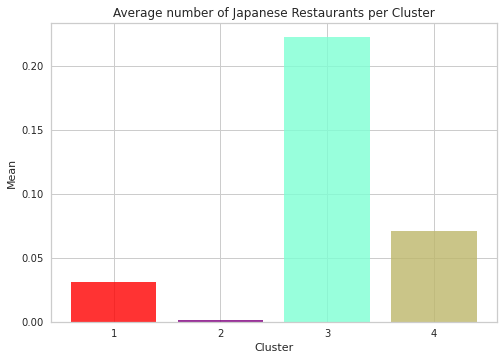

In [67]:
clusters_mean = [df_cluster1['Japanese Restaurant'].mean(),df_cluster2['Japanese Restaurant'].mean(),df_cluster3['Japanese Restaurant'].mean(),
                 df_cluster4['Japanese Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Japanese Restaurants per Cluster')

plt.show()

### Observations
Most of the Japanese Restaurants are in cluster 3 represented by the ligth blue clusters. The Neighborhoods located in the North York area that have the highest average of Japanese Restaurants are Bayview Village and Don Mills North. Even though there is a huge amount of Neighborhoods in cluster 2, there is little to no Japanese Restaurant. We see that in the Downtown Toronto area (cluster 1) has the second last average of Japanese Restaurants. Looking at the nearby venues, the optimum place to put a new Japanese Restaurant is in Downtown Toronto as their are many Neighborhoods in the area but little to no Japanese Restaurants therefore, eliminating any competition. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Japanese restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere.